In [95]:
import lib
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [96]:
raw_image = Image.open("frankfurt_000000_000294_leftImg8bit.png")
raw_image = raw_image.convert("RGB")
plt.imsave("raw_image.png", np.array(raw_image))
gt_image = Image.open("frankfurt_000000_000294_gtFine_color.png")
gt_image = gt_image.convert("RGB")
plt.imsave("GT_image.png", np.array(gt_image))


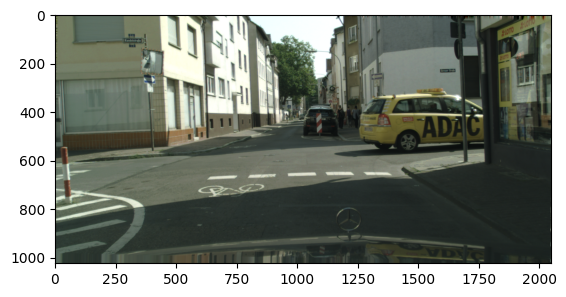

In [97]:
plt.imshow(raw_image)
plt.show()

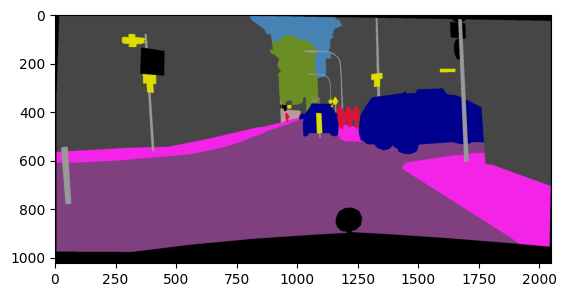

In [98]:
plt.imshow(gt_image)
plt.show()

In [99]:
segmented_image, labels,masks = lib.use_OneFormer(raw_image, add_legend=False, test_colors= True)
#segmented_image, labels,masks = lib.use_DeepLabV3(raw_image, add_legend=False, test_colors= True, model="apple-xx")
#segmented_image, labels, masks = lib.use_BEiT_semantic(raw_image, add_legend=False, test_colors= True, model="large")
#segmented_image, labels, masks = lib.use_MaskFormer(raw_image, add_legend=True, test_colors= False, model="large", dataset="coco")
#segmented_image, labels, masks = lib.use_mask2former(raw_image, add_legend=True, test_colors= False, model="large")
#segmented_image, labels, masks = lib.use_ResNet_panoptic(raw_image, add_legend=True, test_colors= False, model="101")
print(labels)
merged_masks = []
merged_labels = []

for i, label in enumerate(labels):
    if label in merged_labels:
        index = merged_labels.index(label)
        merged_masks[index] = np.maximum(merged_masks[index], masks[i])
    else:
        merged_labels.append(label)
        merged_masks.append(masks[i])

print(len(masks))
print(len(merged_masks))
print(merged_labels)
    


`label_ids_to_fuse` unset. No instance will be fused.


['building', 'signboard, sign', 'person', 'signboard, sign', 'traffic light', 'tree', 'car', 'road, route', 'person', 'car', 'person', 'person', 'signboard, sign', 'sidewalk, pavement', 'person', 'signboard, sign', 'car', 'signboard, sign', 'car', 'sky']
20
9
['building', 'signboard, sign', 'person', 'traffic light', 'tree', 'car', 'road, route', 'sidewalk, pavement', 'sky']


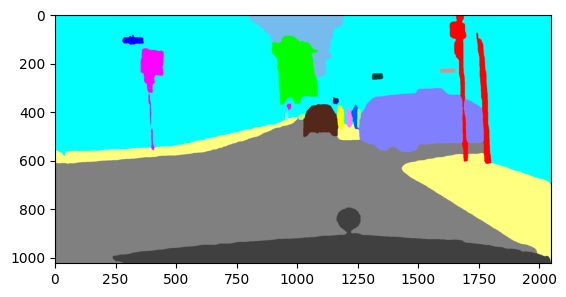

In [100]:
plt.imshow(segmented_image)
plt.show()

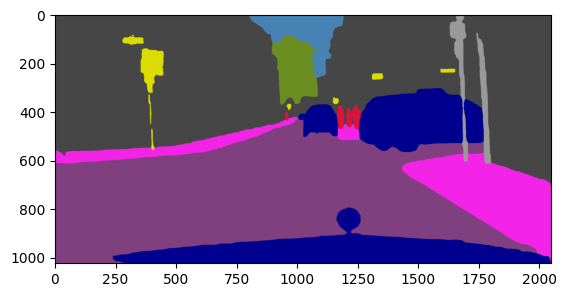

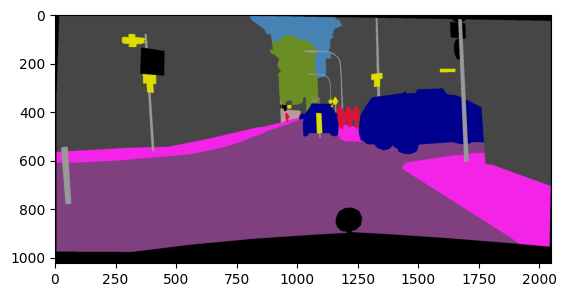

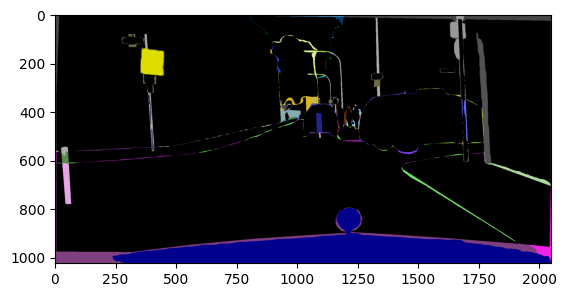

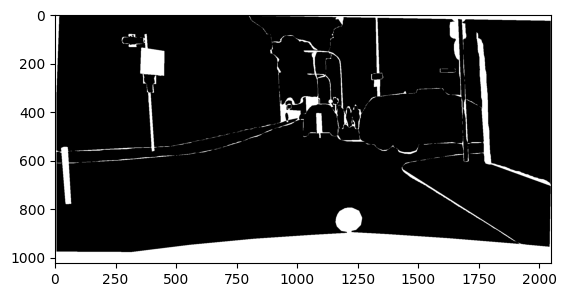

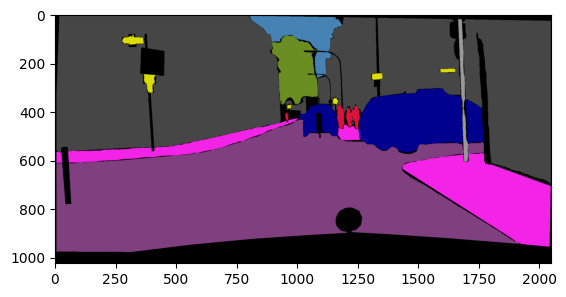

In [101]:

colors = [
    (70,70,70), #1. building
    (220,220,0),#2.signboard
    (220,20,60), #3 person
    (153,153,153), #4 traffic light
    (107,142,35), #5 tree
    (0,0,142), #6 car
    (128, 64, 128), #7 road, route
    (244,35,232), #8 sidewalk, pavement
    (70,130,180) #9 sky
]
name = "test" 


# colors = [
#     (1,1,1),
#     (128, 64, 128), #7 road, route
#     (220,20,60), #3 person
#     (1,1,1),
#     (0,0,142), #6 car
#     (1,1,1),
#     (1,1,1)

# ]

merged_color_image = Image.new("RGB", raw_image.size)

for mask, label, color in zip(merged_masks,merged_labels, colors):

    if not isinstance(mask, Image.Image):
        mask = Image.fromarray(mask)

    mask_colored = Image.new("RGB", mask.size)
    mask_colored.paste(color, mask=mask)
    plt.imshow(mask_colored)
    #plt.title(label)
    #plt.show()

    merged_color_image.paste(mask_colored, mask=mask)

plt.imshow(merged_color_image)
plt.show()
plt.imsave(f"{name}.png", np.array(merged_color_image))

plt.imshow(gt_image)
plt.show()

differece = np.array(merged_color_image) - np.array(gt_image)
plt.imshow(differece)
plt.show()

#to black and white
differece = np.sum(differece, axis=2)
differece = differece > 0
plt.imshow(differece, cmap="gray")
plt.show()
plt.imsave(f"{name}_difference.png", differece, cmap="gray")

#use difference as a mask
differece = Image.fromarray(differece)
#differece = differece.convert("L")
merged_color_image.paste((0,0,0), mask=differece)
plt.imshow(merged_color_image)
plt.show()
plt.imsave(f"{name}_difference_color.png", np.array(merged_color_image))



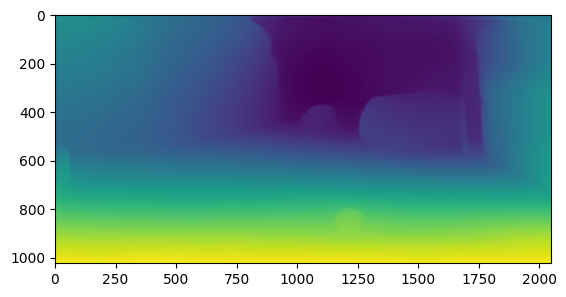

In [102]:
depth_image,_ = lib.use_MiDaS_Hybrid(merged_color_image)

plt.imshow(depth_image)
plt.show()

In [115]:
#differece = differece.convert("RGB")

# Ensure differece is a 3D array
#differece = np.array(differece)
#if differece.ndim == 2:
#	differece = np.stack((differece,)*3, axis=-1)

semantic_map = lib.create_semantic_3D_map(segmented_color_image=differece, depth_image=depth_image, fx = 1000, fy=-1000, z_scale = 0.01)

In [116]:
lib.view_cloude_point(semantic_map)